In [29]:
%matplotlib notebook

%matplotlib inline

import sys

if "." not in sys.path:
    sys.path.insert(0, ".")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

# Transformation
from bioinfokit.analys import norm

# 2D Visualization
from sklearn.decomposition import PCA
from openTSNE import TSNE
import umap

# metrics
from dcor import distance_correlation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import OneHotEncoder

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.stats import nbinom

from utils import *


import time
import pickle
import memory_profiler
from tqdm import tqdm

%load_ext memory_profiler

from pathlib import Path
import black
import jupyter_black

jupyter_black.load(line_length=79)
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
intermediate_path = Path("../results/intermediate")
data_path = Path("./data")
plt.style.use("../matplotlib_style.txt")

np.random.seed(42)

# TODO: Description of the data in section 1
# TODO: make plots interactive
# TODO: Describe algorithms and metrics in section 3
# TODO: Show electrophyisology data in section 3
# TODO: Implement NBMM
# TODO: Section 5

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# 0. Data Loading 

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [30]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [31]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)
data_exons

Count matrix shape (exon):   (1329, 42466)


,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

print("Number of genes:", len(genes))
genes

Number of genes: 42466


array(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', ..., 'n-R5s98',
       'n-TSaga9', 'n-TStga1'], dtype=object)

### Cluster colors

In [33]:
cluster_colors = np.load(data_path / "cluster_colors.npy")
cluster_colors.shape

(1329,)

In [34]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)
rna_type.shape

(1329,)

In [35]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)
len(dict_rna_type_colors)

88

### Electrophysiological features

In [36]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [37]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [38]:
np.sum(np.isnan(ephysData_filtered))

0

# 1. Data Inspection

**Description of the relevant data:**
- exonCounts: Array of dimensions $n_{cells} \times n_{genes}$. Holds the read counts of the genes for every cell.
- exonLengths: Array of dimensions $n_{genes} \times 1$. Holds the lengths of the respective genes. Needed for some normalization techniques.
- genes: Array of dimensions $n_{genes} \times 1$. Holds the names of the genes.
- cluster_colors: Array of dimensions $n_{cells} \times 1$. Holds membership information to a cluster of each cell.
- rna_type: Array of dimensions $n_{cells} \times 1$. Holds information about the RNA type of each cell.
- ephysData: Array of dimensions $n_{cells} \times 29$. Holds values of overall 29 explored electrophysical features of each cell.
- ephysNames: Names of the explored electrophysical features.
 

In [39]:
# print shapes of relevant data
print("shape of exonCounts: ", exonCounts.shape)
print("shape of exonLengths: ", exonLengths.shape)
print("shape of genes: ", genes.shape)
print("shape of cluster_colors: ", cluster_colors.shape)
print("shape of rna_type: ", rna_type.shape)
print("shape of ephysData: ", ephysData.shape)
# print("shape of ephysData_filtered: ", ephysData_filtered.shape) # emitted because dimensions do not fit to the rest of the data

shape of exonCounts:  (1329, 42466)
shape of exonLengths:  (42466,)
shape of genes:  (42466,)
shape of cluster_colors:  (1329,)
shape of rna_type:  (1329,)
shape of ephysData:  (1329, 29)



We begin by removing all genes that exhibit no expression.

In [40]:
# kick out genes with no expression
keepgenes = np.sum(exonCounts, axis=0) > 0
exonCounts = exonCounts[:, keepgenes]
genes = genes[keepgenes]
exonLengths = exonLengths[keepgenes]

## 1.1 Feature Selection

In accordance with the methodology proposed by Kobak & Berens (2019), we choose features (genes) based on their mean-dropout relationship, as described by Andrews and Hemberg (2018). 

In [41]:
# exclude genes with less than 32 counts in all but 10 cells
cmin = 32
n_cells = np.sum(exonCounts >= cmin, axis=0)
exclude = n_cells < 10

exonCounts_filtered = exonCounts[:, ~exclude]
genes_filtered = genes[~exclude]
exonLengths_filtered = exonLengths[~exclude]

variable_exonLengths = exonLengths[~exclude]

# Calculate Mean Log Non-Zero Expression and Dropout Rate for Each Gene
# dropout rate
d_g = np.mean(exonCounts_filtered <= cmin, axis=0)

# mean log non-zero expression
# write ones for every value that is less than or equal to cmin (log(1) = 0)
exonCounts_filtered[exonCounts_filtered <= cmin] = 1
variable_exonCount_log = np.log2(exonCounts_filtered)
m_g = np.array(
    [
        np.mean(
            variable_exonCount_log[:, i][variable_exonCount_log[:, i] != 0]
        )
        for i in range(variable_exonCount_log.shape[1])
    ]
)

In [42]:
# boundary function to get the threshold (adopted from Kobak & Berens 2019)
def boundary(mu, b):
    return np.exp(-1.5 * (mu - b)) + 0.02


# perform binary search to get 500 genes that fullfil the criteria
def binary_search(mu, num_genes):
    """
    Binary search for the optimal value of theta
    """
    alpha_min = 0
    alpha_max = 500
    alpha = (alpha_min + alpha_max) / 2
    i = 0
    while np.sum(d_g > boundary(mu, alpha)) != num_genes and i < 1000:
        if np.sum(d_g > boundary(mu, alpha)) < num_genes:
            alpha_max = alpha
        else:
            alpha_min = alpha
        alpha = (alpha_min + alpha_max) / 2
        # print(alpha)
        i += 1
    return alpha, d_g > boundary(mu, alpha)


offset, idx = binary_search(m_g, 500)

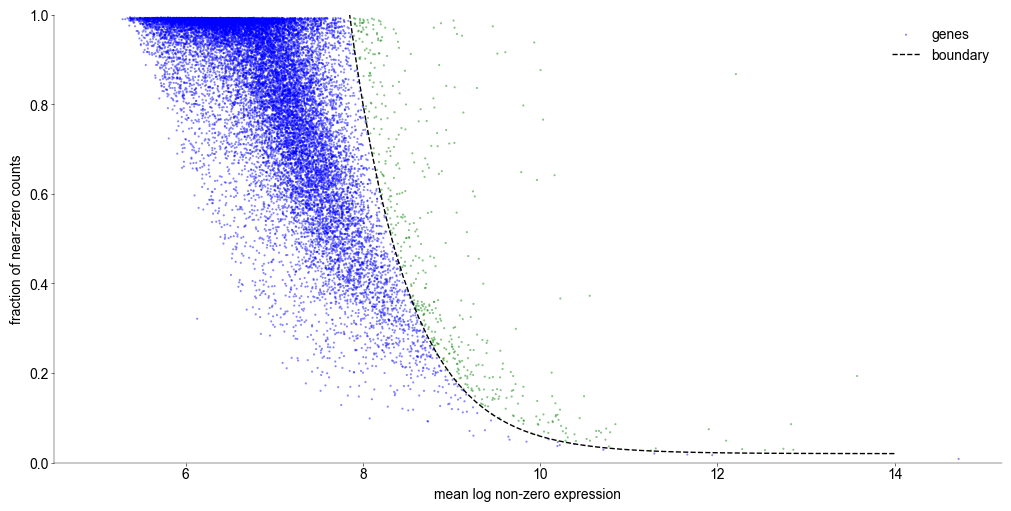

In [43]:
# TODO: make this interactive ?
x = np.linspace(5, 14, 100)

boundary_colors = np.array(["blue", "green"])[
    (d_g > boundary(m_g, offset)).astype(int)
]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(m_g, d_g, s=1, c=boundary_colors, label="genes", alpha=0.5)
ax.set_xlabel("mean log non-zero expression")
ax.set_ylabel("fraction of near-zero counts")
ax.set_ylim(0, 1)
ax.plot(
    x, boundary(x, offset), color="black", linestyle="--", label="boundary"
)

ax.legend()

plt.show()

In [44]:
exonCounts_filtered = exonCounts_filtered[:, idx]
genes_filtered = genes_filtered[idx]
exonLengths_filtered = exonLengths_filtered[idx]

## 1.1. Compute Statistics

Do we want to calculate the statistics of the filtered data or of the exonCounts before manipulating it? 

In [45]:
# Compute the average expression for each gene
avg_expr = np.mean(exonCounts_filtered, axis=0)
frac_zeros = np.mean(exonCounts_filtered == 0, axis=0)

# compute variance
var_expr = np.var(exonCounts_filtered, axis=0)

# Compute fano factor
fano_factor = var_expr / avg_expr

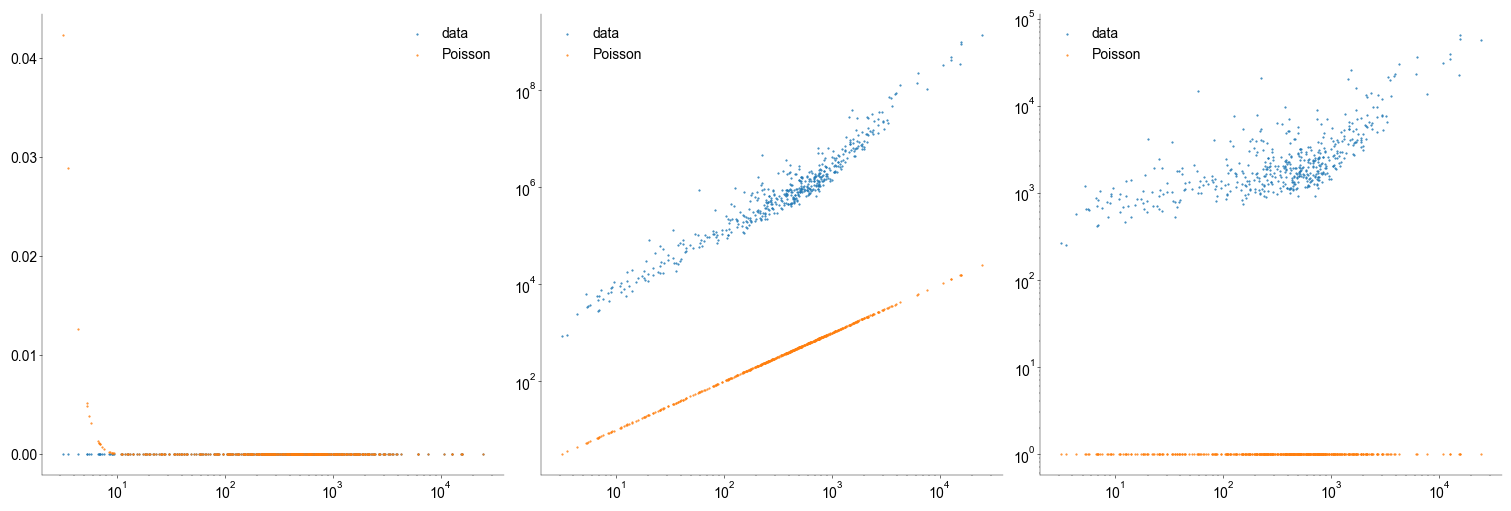

In [46]:
# visualize that the distribution does indeed not follow a poisson distribution

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(avg_expr, frac_zeros, s=1, label="data")
axs[0].scatter(avg_expr, np.exp(-avg_expr), s=1, label="Poisson")

axs[1].scatter(avg_expr, var_expr, s=1, label="data")
axs[1].scatter(avg_expr, avg_expr, s=1, label="Poisson")

axs[2].scatter(avg_expr, fano_factor, s=1, label="data")
axs[2].scatter(avg_expr, np.ones_like(avg_expr), s=1, label="Poisson")

for i, ax in enumerate(axs):
    ax.set_xscale("log")
    if i != 0:
        ax.set_yscale("log")
    ax.legend()

plt.show()

**Analysis:** We can see what was already given in the task description, i.e. that the data does not follow a Poisson distribution because it is not acquired via UMI.

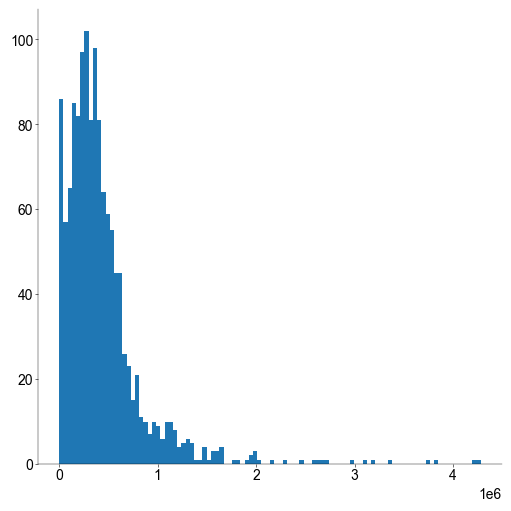

In [47]:
# plot sequencing depth of each cell

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.sum(exonCounts_filtered, axis=1), bins=100)

plt.show()

# 2. Data Normalization and Transformation


In the exercise sheet related to transcriptomic data analysis, we standardized the counts by expressing them as counts per median sequencing depth. Since the data does not consist of unique molecular identifier (UMI) counts, we applied two distinct normalization methods: counts per million (CPM) and reads per kilobase per million (RPKM). Additionally, we applied both log-transformation and square root-transformation to the normalized data in each case.


## 2.1. Counts per million (CPM)

In order to obtain CPM, we have to perform the following calculation for each cell:

$$ CPM = \frac{\text{Read counts mapped to gene}}{\text{Total number of mapped reads}} \times 10^6 $$

For this, the bioinfokit.analys library is used.


In [48]:
# convert exonCounts to dataframe
df = pd.DataFrame(exonCounts_filtered.T, columns=cells, index=genes_filtered)

In [49]:
# Normalization: CPM
nm = norm()
nm.cpm(df)
cpm_df = nm.cpm_norm


# Transformation: Log2 and sqrt transform
cpm_counts = cpm_df.values.T
cpm_counts_log = np.log2(cpm_counts + 1)  # + 1 to avoid log(0)
cpm_counts_sqrt = np.sqrt(cpm_counts)

## 2.3. Reads per kilobase per million (RPKM)

RPKM addresses the issue of variations in gene lengths and sequencing depths:

$$ RPKM = \frac{{\text{Number of uniquely mapped reads to the gene}}}{{\text{gene length in KB} \times \text{Total mapped reads in the sample}}} \times 10^6$$

Again, we use the bioinfokit package to obtain the normalized counts.

In [50]:
# add column with lengths to df
df["length"] = exonLengths_filtered

# Normalization
nm = norm()
nm.rpkm(df=df, gl="length")
rpkm_df = nm.rpkm_norm

# Log and sqrt transform
rpkm_counts = rpkm_df.values.T
rpkm_counts_log = np.log(rpkm_counts + 1)
rpkm_counts_sqrt = np.sqrt(rpkm_counts)

# 3. Two-dimensional Visualization

The aim of this section is to generate two-dimensional visualizations of our very high-dimensional data. This task is accomplished by employing two algorithms, namely TSNE and UMAP. TSNE preserves local structure and is visually appealing but computationally expensive. UMAP is faster, scalable, and preserves both local and global structures, but it may not produce visually pleasing representations as effectively as TSNE. A more extensive description of the algorithms is provided in the corresponding sections.

To ensure computational feasibility for dimensionality reduction, we follow the procedure of Kobak and Berens (2019) and perform it on the first fifty principal components.

- TODO: Grid-Search over Parameters

- TODO: Evaluation Schemes

--> both their own section respectively

In [51]:
# create a dictionary with the different count types to make it easy to iterate over them

count_dict = {
    "unnormalized": {
        "raw": exonCounts_filtered,
        "log": np.log2(exonCounts_filtered + 1),
        "sqrt": np.sqrt(exonCounts_filtered),
    },
    "cpm": {
        "raw": cpm_counts,
        "log": cpm_counts_log,
        "sqrt": cpm_counts_sqrt,
    },
    "rpkm": {
        "raw": rpkm_counts,
        "log": rpkm_counts_log,
        "sqrt": rpkm_counts_sqrt,
    },
}

In [52]:
cluster_colors is np.ndarray, type(cluster_colors) is np.ndarray

(False, True)

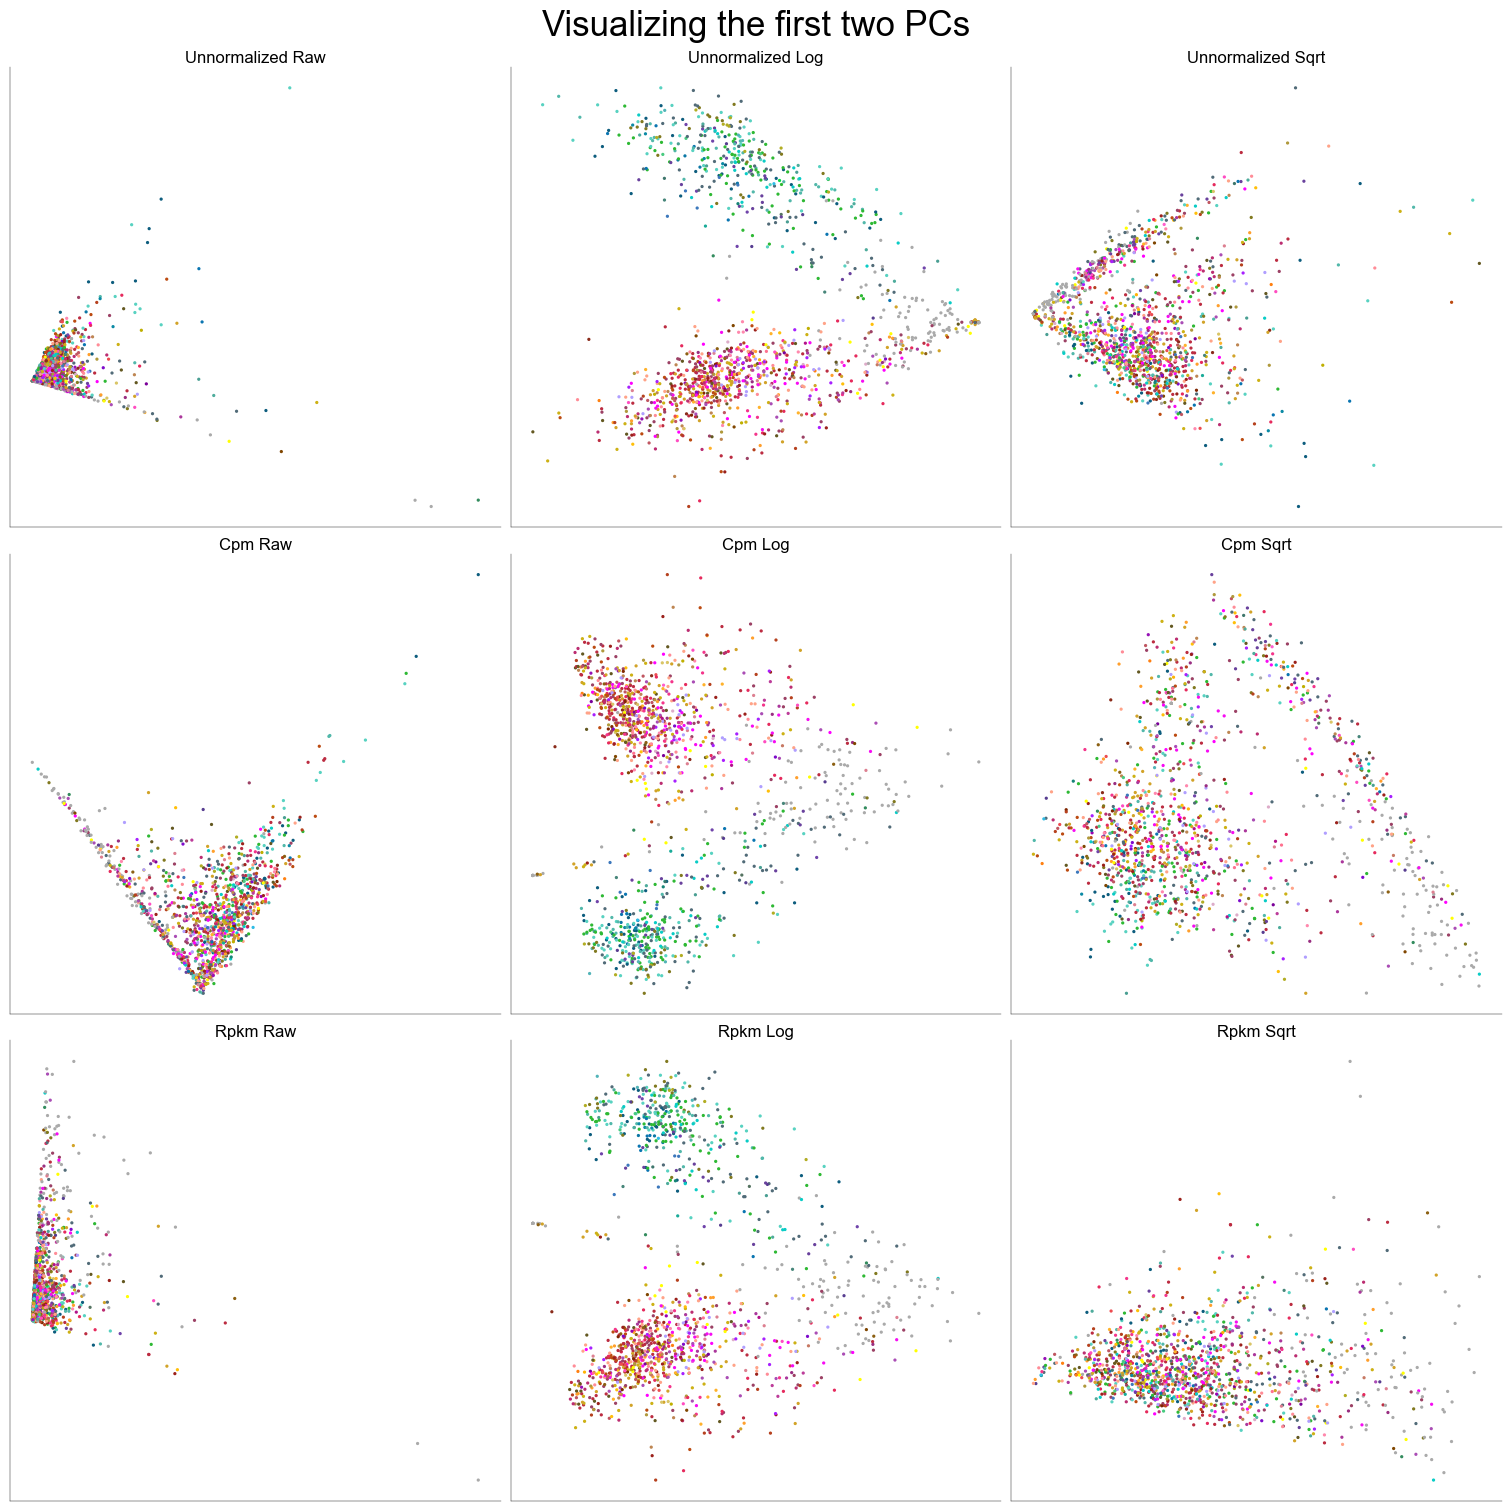

In [53]:
# perform PCA fit
pca = PCA(n_components=50)
pca_results = dict()
for norm_key, sub_dict in count_dict.items():
    pca_results[norm_key] = dict()
    for trans_key, counts in sub_dict.items():
        pca_results[norm_key][trans_key] = pca.fit_transform(counts)

# plot PCA results
plot_2d_vis(pca_results, "Visualizing the first two PCs", cluster_colors)

In [54]:
pca_results["cpm"]["raw"].shape

(1329, 50)

**Qualitative Analysis:** It appears that PCA alone is insufficient to unveil the clusters. Thus, it becomes necessary, as anticipated, to employ TSNE or UMAP. Presently, there has been no assessment of the various normalization methods' quality.

## 3.1. TSNE

- TODO: TSNE description or is this overkill?

In [55]:
# perform t-SNE of PCA results with default parameters
tsne = TSNE()
tsne_results = dict()
for norm_key, sub_dict in pca_results.items():
    tsne_results[norm_key] = dict()
    for trans_key, result in sub_dict.items():
        tsne_results[norm_key][trans_key] = tsne.fit(result)

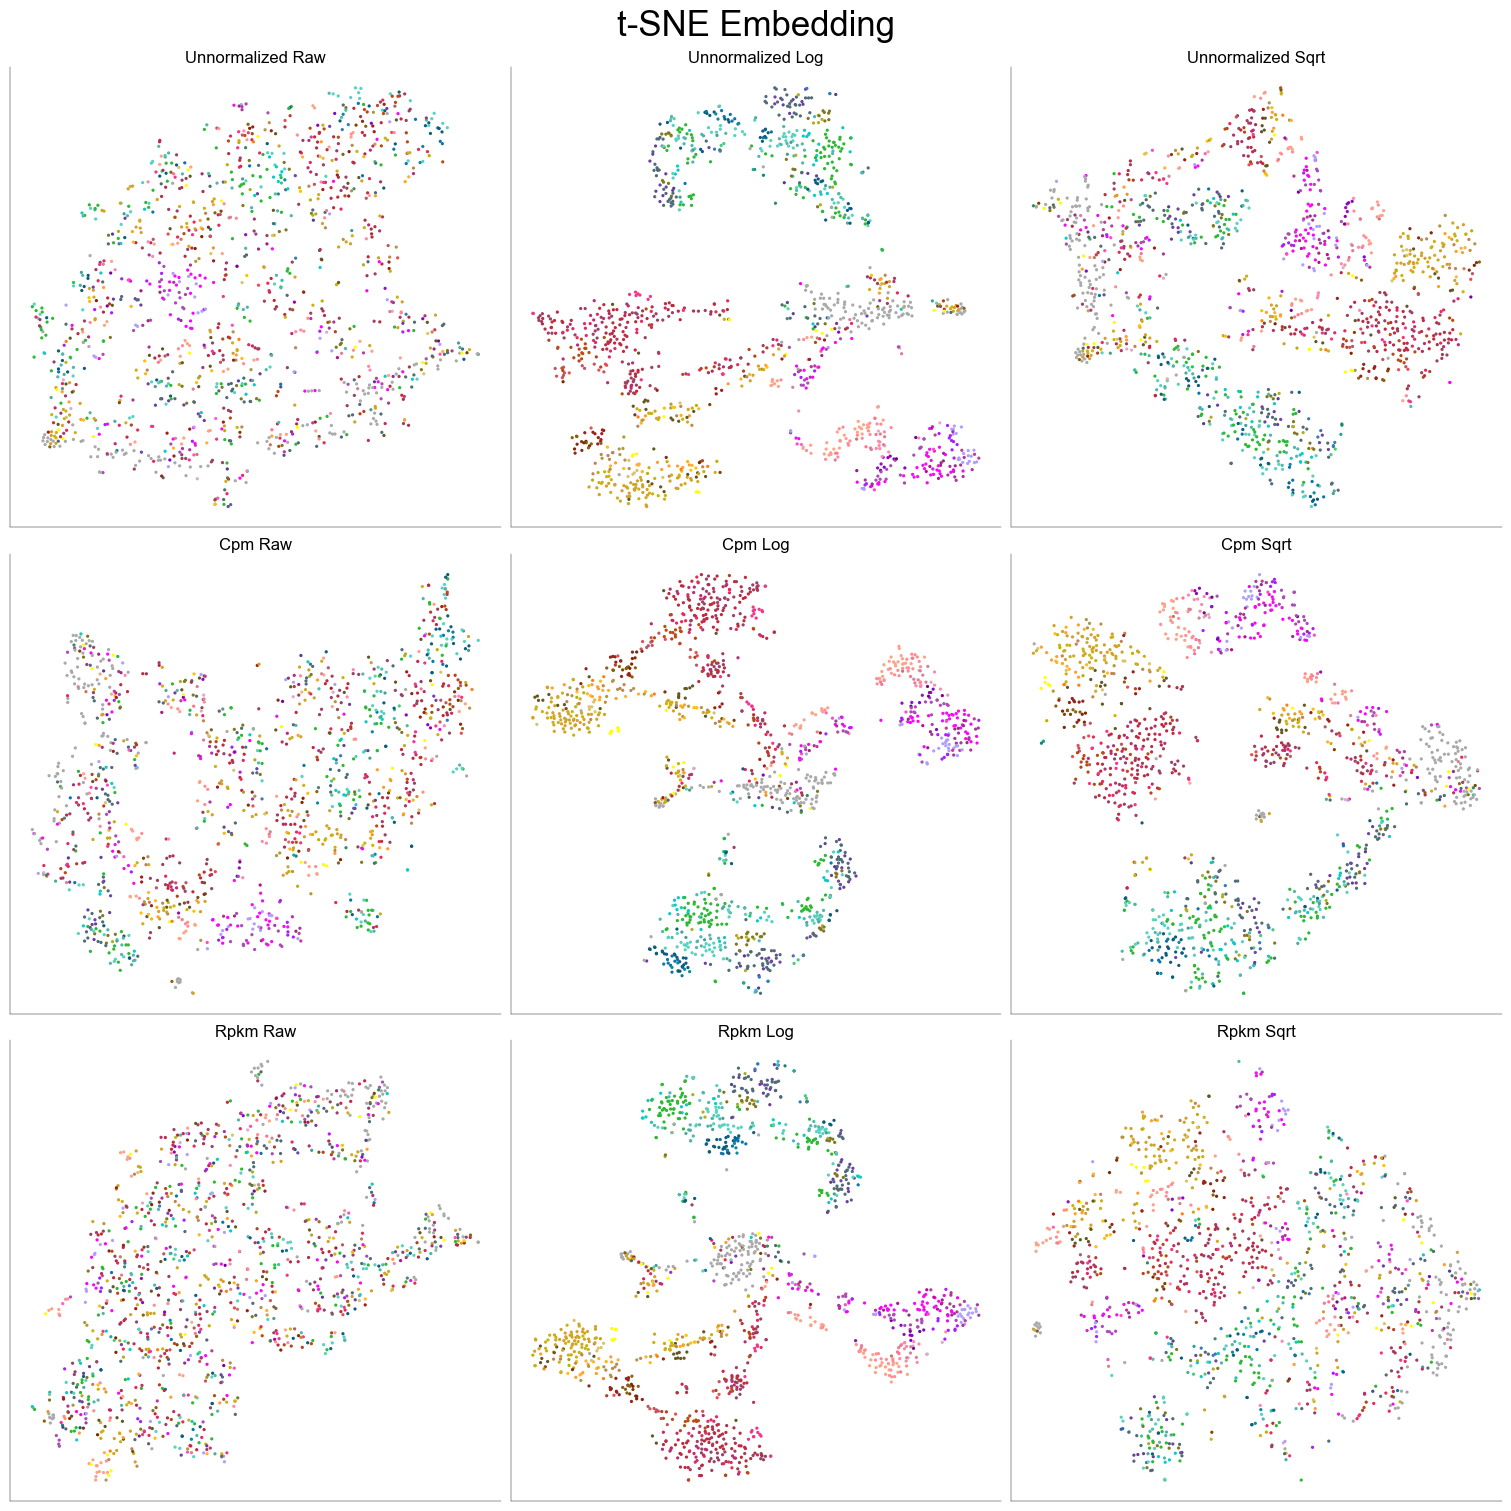

In [56]:
plot_2d_vis(tsne_results, "t-SNE Embedding", cluster_colors)

**Qualitative Analysis:** The original data (left column) does not exhibit satisfactory clustering results. The square-root transformation (right column) also shows limitations, especially when dealing with unnormalized and RPKM-normalized data. On the other hand, log-transformations (middle column) appear to yield the best results, although it is evident that the ground truth does not perfectly align with the cluster structure revealed by TSNE.

## 3.2. UMAP

- TODO: description of the algorithm or overkill?

In [57]:
umap_func = umap.UMAP()
umap_results = dict()
for norm_key, sub_dict in pca_results.items():
    umap_results[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        umap_results[norm_key][trans_key] = umap_func.fit_transform(pca_result)

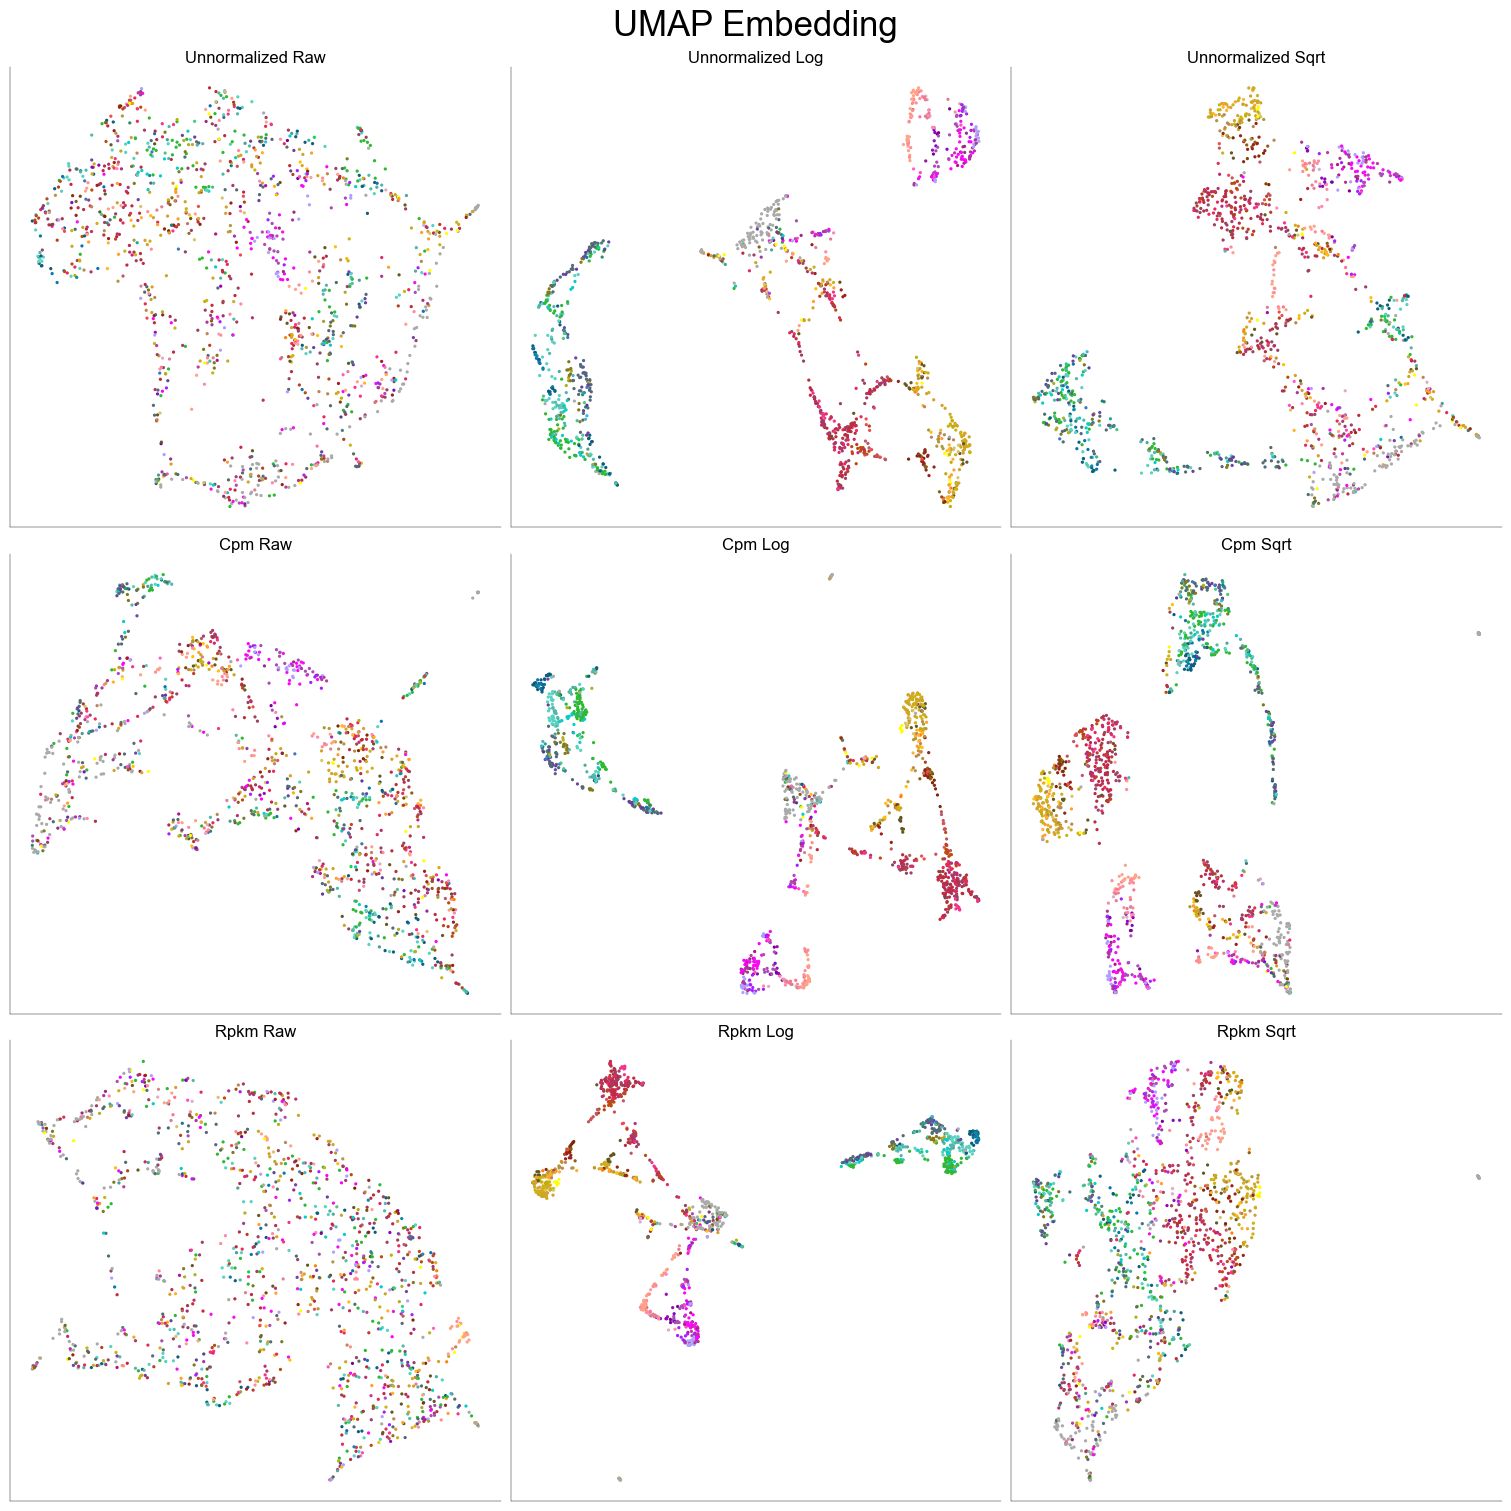

In [58]:
plot_2d_vis(umap_results, "UMAP Embedding", cluster_colors)

**Qualitative Analysis:** Similar to the previous observation, the original data (left column) does not produce satisfactory results in terms of clustering. The square-root transformation (right column) reveals the cluster structure better than TSNE. Nevertheless, our conclusion is that log-transformations (middle column) offer the most meaningful two-dimensional visual representation of the underlying ground truth cluster structure. 

As a result, we choose to focus our further, quantitative analysis solely on the middle column, disregarding the unnormalized log-transformed data (since normalization is standard in the literature). 

In [59]:
# remove keys from result dictionary

result_dicts = [count_dict, pca_results, tsne_results, umap_results]

remove_norms = ["unnormalized"]  # ["raw", "cpm", "rpkm"]
remove_transforms = ["raw", "sqrt"]  # ["counts", "log", "sqrt"]

for result_dict in result_dicts:
    for norm in remove_norms:
        try:
            del result_dict[norm]
        except KeyError:
            pass

for result_dict in result_dicts:
    for norm_key, sub_dict in result_dict.items():
        for trans in remove_transforms:
            try:
                del sub_dict[trans]
            except KeyError:
                pass

## 3.4. Quantitative Analysis

- Metrics
- Gridsearch (describe hyperparameter spaces)
- 


### 3.4.1. Implementation of different Metrics

- distance correlation
- knn (normalized)
- combined (?)




In [60]:
# Calculate distance correlation
pca_dc = dict()
tsne_dc = dict()
umap_dc = dict()
for key, result in pca_results.items():
    pca_dc[key] = distance_correlation(result, result[:, :2])
    tsne_dc[key] = distance_correlation(result, tsne_results[key])
    umap_dc[key] = distance_correlation(result, umap_results[key])

print(f"PCA distance correlations: {pca_dc}")
print(f"t-SNE distance correlations: {tsne_dc}")
print(f"UMAP distance correlations: {umap_dc}")

# TODO: Results different than Leanders, conincidence?

TypeError: unhashable type: 'slice'

In [ ]:
str_rna_types = np.array([str(r) for r in rna_type])

In [ ]:
# TODO is this what they meant? To discuss...
def get_knn_score(input, gt_labels=str_rna_types):
    max_accuracy = 0
    for neighbor in range(1, 30):
        knn = KNeighborsClassifier(n_neighbors=neighbor)
        X_train, X_test, y_train, y_test = train_test_split(
            input, gt_labels, random_state=42
        )
        knn.fit(X_train, y_train)
        prediction = knn.predict(X_test)
        accuracy = accuracy_score(y_test, prediction)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_neighbor = neighbor
    return best_neighbor, max_accuracy

    # Note that the recall of the knn classifier is the same as the accuracy, for any of the averaging mode, as recall is a binary metric
    return [
        accuracy_score(y_test, prediction),
        recall_score(y_test, prediction, average="micro"),
    ]


def print_knn_scores(result_dict, title, f=lambda x: x):
    out_dict = dict()
    for key, result in result_dict.items():
        out_dict[key] = dict()
        out_dict[key].update(
            zip(
                ["num_neighbors", "accuracy"],
                get_knn_score(f(result)),
            )
        )

    print(f"{title} knn accuracy/recall: {out_dict}")
    return out_dict


print(
    "Note that the recall of the knn classifier is the same as the accuracy, as recall is a binary metric\n"
)
high_dim_knn_score = print_knn_scores(pca_results, "PCA")
pca_knn_score = print_knn_scores(pca_results, "PCA 2D", lambda x: x[:, :2])

tsne_knn_score = print_knn_scores(tsne_results, "t-SNE")
umap_knn_score = print_knn_scores(umap_results, "UMAP")

Note that the recall of the knn classifier is the same as the accuracy, as recall is a binary metric

PCA knn accuracy/recall: {'cpm.raw': {'num_neighbors': 25, 'accuracy': 0.26426426426426425}, 'cpm.log': {'num_neighbors': 13, 'accuracy': 0.4864864864864865}, 'cpm.sqrt': {'num_neighbors': 6, 'accuracy': 0.4024024024024024}, 'rpkm.raw': {'num_neighbors': 1, 'accuracy': 0.15315315315315314}, 'rpkm.log': {'num_neighbors': 9, 'accuracy': 0.4954954954954955}, 'rpkm.sqrt': {'num_neighbors': 28, 'accuracy': 0.3033033033033033}}
PCA 2D knn accuracy/recall: {'cpm.raw': {'num_neighbors': 25, 'accuracy': 0.11711711711711711}, 'cpm.log': {'num_neighbors': 24, 'accuracy': 0.1831831831831832}, 'cpm.sqrt': {'num_neighbors': 25, 'accuracy': 0.14414414414414414}, 'rpkm.raw': {'num_neighbors': 29, 'accuracy': 0.10510510510510511}, 'rpkm.log': {'num_neighbors': 26, 'accuracy': 0.18618618618618618}, 'rpkm.sqrt': {'num_neighbors': 17, 'accuracy': 0.10510510510510511}}
t-SNE knn accuracy/recall: {'cpm.raw'

To achieve comparability in terms of the 2D respresentation, we calculate the accuracy score of the respective 2D representation divided by the knn accuracy 50-dimensional PCA respresentation over the thus normalizing it to the $[0, 1]$ interval

In [ ]:
def normalize_knn_scores(scores):
    out_dict = dict()
    for key, score in scores.items():
        out_dict[key] = dict()
        out_dict[key] = score["accuracy"] / high_dim_knn_score[key]["accuracy"]

    return out_dict


print(f"PCA 2D knn normalized accuracy: {normalize_knn_scores(pca_knn_score)}")
print(f"t-SNE knn normalized accuracy: {normalize_knn_scores(tsne_knn_score)}")
print(f"UMAP knn normalized accuracy: {normalize_knn_scores(umap_knn_score)}")

PCA 2D knn normalized accuracy: {'cpm.raw': 0.4431818181818182, 'cpm.log': 0.3765432098765432, 'cpm.sqrt': 0.35820895522388063, 'rpkm.raw': 0.6862745098039217, 'rpkm.log': 0.37575757575757573, 'rpkm.sqrt': 0.34653465346534656}
t-SNE knn normalized accuracy: {'cpm.raw': 0.8181818181818182, 'cpm.log': 0.9259259259259259, 'cpm.sqrt': 0.8955223880597015, 'rpkm.raw': 0.9411764705882354, 'rpkm.log': 0.896969696969697, 'rpkm.sqrt': 0.801980198019802}
UMAP knn normalized accuracy: {'cpm.raw': 0.7954545454545455, 'cpm.log': 0.9074074074074073, 'cpm.sqrt': 0.8358208955223881, 'rpkm.raw': 0.8235294117647058, 'rpkm.log': 0.8848484848484849, 'rpkm.sqrt': 0.8415841584158417}


Now that we have two scores that are both in the interval $[0, 1]$ we can combine them, i.e. taking the mean, to create an even more informed score

In [ ]:
def get_combined_score(high_dim_matrix, low_dim_matrix):
    _, high_dim_accuracy = get_knn_score(high_dim_matrix)
    _, accuracy = get_knn_score(low_dim_matrix)
    dc = distance_correlation(high_dim_matrix, low_dim_matrix)
    return np.mean([accuracy / high_dim_accuracy, dc])


def get_all_combined_scores(result_dict, f=lambda x: x):
    out_dict = dict()
    for key, result in result_dict.items():
        out_dict[key] = dict()
        out_dict[key] = get_combined_score(pca_results[key], f(result))

    return out_dict


print(
    f"PCA 2D combined score: {get_all_combined_scores(pca_results, lambda x: x[:, :2])}"
)
print(f"t-SNE combined score: {get_all_combined_scores(tsne_results)}")
print(f"UMAP combined score: {get_all_combined_scores(umap_results)}")

PCA 2D combined score: {'cpm.raw': 0.7065495185463431, 'cpm.log': 0.6380644652936167, 'cpm.sqrt': 0.6496330032140157, 'rpkm.raw': 0.8371848096757566, 'rpkm.log': 0.6371418048694134, 'rpkm.sqrt': 0.6418786907546792}
t-SNE combined score: {'cpm.raw': 0.856168742428429, 'cpm.log': 0.8466585049607491, 'cpm.sqrt': 0.8411346834561633, 'rpkm.raw': 0.9060399993260673, 'rpkm.log': 0.8275943150000696, 'rpkm.sqrt': 0.8114733694472154}
UMAP combined score: {'cpm.raw': 0.8379412497833932, 'cpm.log': 0.8270897703567771, 'cpm.sqrt': 0.7886367494987061, 'rpkm.raw': 0.852380578440839, 'rpkm.log': 0.8121358228404043, 'rpkm.sqrt': 0.7979915713893699}


### 3.4.2. Gridsearch over TSNE hyperparameters

As mentioned earlier, the TSNE algorithm involves two hyperparameters that the user needs to provide, and these values can be optimized. In the following we intend to employ a grid search scheme over discrete set of values to determine the best ones. (QUESTION: How do we choose the values contained in the space?? )

In [61]:
# load results
pickle_in = open(intermediate_path / "tsne_results.pkl", "rb")
tsne_results, tsne_dc, tsne_hyperparams = pickle.load(pickle_in)
pickle_in.close()

# 4. Clustering



## 4.1. Leiden Clustering

## 4.2. Gaussian Mixture Models

In [62]:
def choose_n_clusters(
    X: np.ndarray, mm_class, max_clusters: int = 10, min_n_clusters: int = 1
):
    min_bic = np.inf
    for n_clusters in tqdm(range(min_n_clusters, max_clusters + 1)):
        mm = mm_class(n_components=n_clusters)
        mm.fit(X)
        bic = mm.bic(X)
        if bic < min_bic:
            min_bic = bic
            best_n_clusters = n_clusters
            best_mm = mm
    print(f"Best result: {best_n_clusters} clusters, BIC = {min_bic}")
    return best_n_clusters, best_mm.predict(X)

In [72]:
_, counts = np.unique(cluster_colors, return_counts=True)

max_n_clusters = 50
print(f"Maximum number of clusters: {max_n_clusters}")
gmm_labels = dict()
for norm_key, sub_dict in pca_results.items():
    gmm_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        _, gmm_labels[norm_key][trans_key] = choose_n_clusters(
            pca_result, GaussianMixture, max_n_clusters
        )

Maximum number of clusters: 50


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


Best result: 49 clusters, BIC = 373918.6265221408


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]

Best result: 3 clusters, BIC = 348620.18865739246


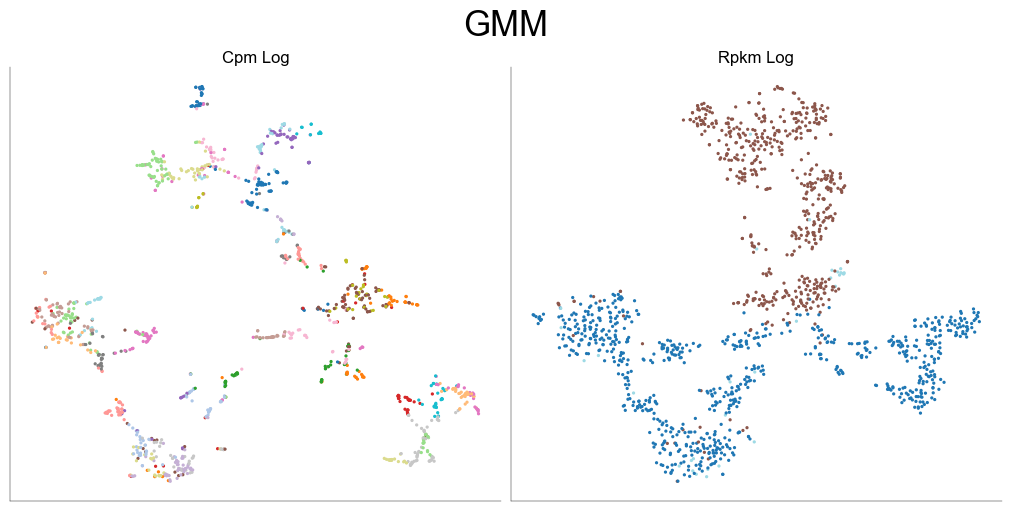

In [75]:
plot_2d_vis(tsne_results, "GMM", gmm_labels, transpose=True)

## 4.3. Negative Binomial Mixture Model

**Explaination of the Model:**

In [87]:
np.random.seed(42)
_, counts = np.unique(cluster_colors, return_counts=True)

max_n_clusters = 100
print(f"Maximum number of clusters: {max_n_clusters}")
nbmm_labels = dict()
for norm_key, sub_dict in count_dict.items():
    nbmm_labels[norm_key] = dict()
    for trans_key, result in sub_dict.items():
        _, nbmm_labels[norm_key][trans_key] = choose_n_clusters(
            result, NBMM, max_n_clusters
        )

# save results
pickle_out = open(intermediate_path / "nbmm_results.pkl", "wb")
pickle.dump((nbmm_labels), pickle_out)
pickle_out.close()
nbmm_labels["cpm"]["log"].shape

Maximum number of clusters: 100


100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Best result: 98 clusters, BIC = 2975839.121976495


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]

Best result: 19 clusters, BIC = 2187549.777833474


(1329,)

In [84]:
# load results
pickle_in = open(intermediate_path / "nbmm_results.pkl", "rb")
nbmm_labels = pickle.load(pickle_in)
pickle_in.close()

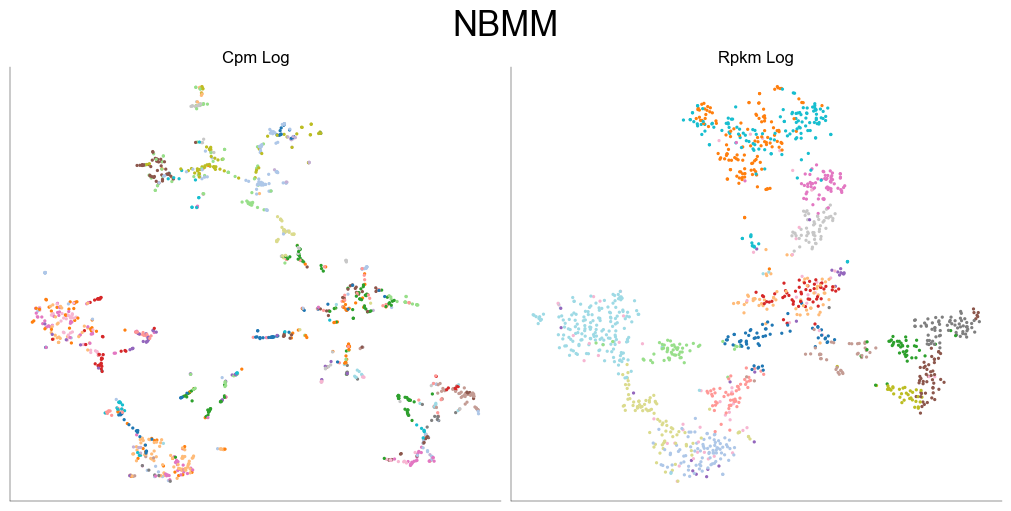

In [88]:
plot_2d_vis(tsne_results, "NBMM", nbmm_labels, transpose=True)

# 5. Correlation in between Electrophysiological Features and Genes/PCs

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    